# **THỰC HÀNH MỘT DỰ ÁN HỌC MÁY TỪ ĐẦU ĐẾN CUỐI**
# **PHÂN TÍCH VÀ TÌM MÔ HÌNH DỰ ĐOÁN GIÁ NHÀ Ở BANG CALIFORNIA**
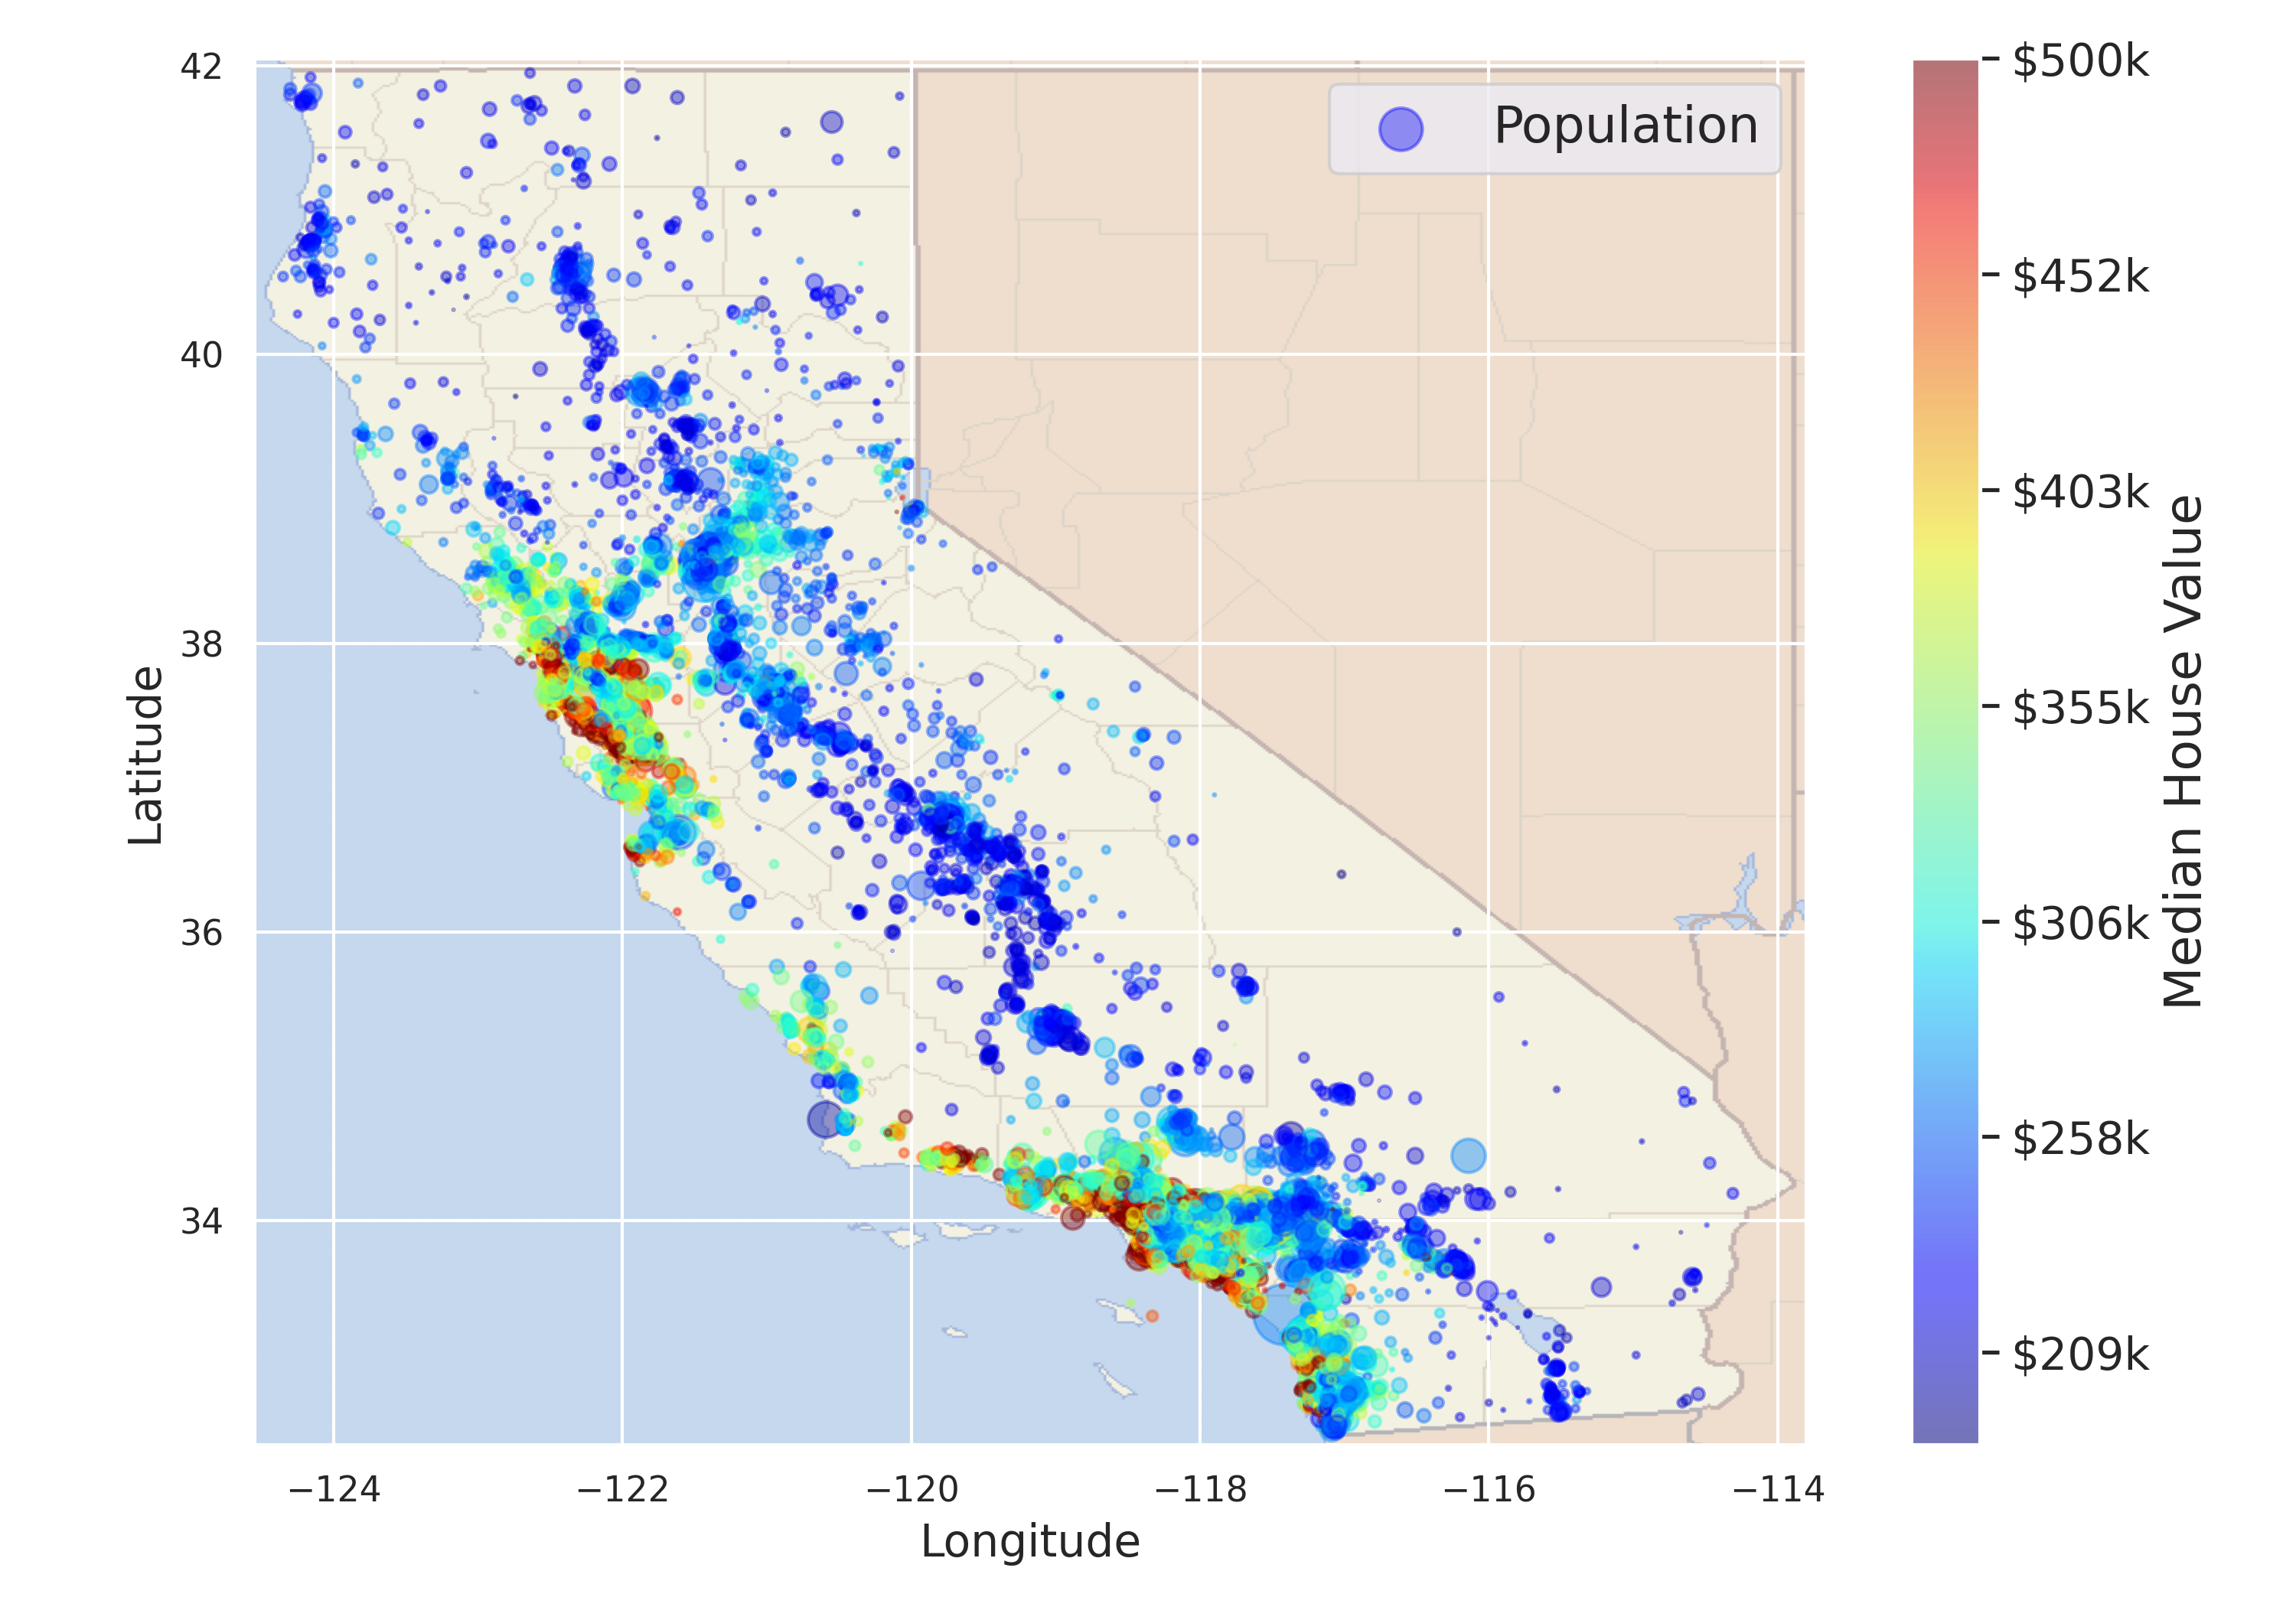

# 1. Nhìn vào bức tranh tổng thể
Bài toán của chúng ta sử dụng tập dữ liệu điều tra dân số của bang California được lấy từ thư viện **scikit-learn** để xây dựng mô hình dự đoán giá nhà tại bang. Tập dữ liệu này dựa trên kết quả của cuộc điều tra dân số 1990 ở bang **California**, bao gồm các số liệu như dân số, thu nhập trung vị và giá nhà trung vị cho từng *block* ở **California**. Chúng ta có thể xem các thông tin của tập dữ liệu này ở [đây](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset). *Block* là đơn vị địa lý nhỏ nhất mà cục điều tra dân số Hoa Kỳ sử dụng để công bố dữ liệu mẫu (một block thường có dân số từ 600 đến 3,000 người). Để thuận tiện, ta sẽ gọi block là các "quận". Mô hình của ta sẽ cần học từ tập dữ liệu này và dự đoán giá nhà trung vị cho một quận bất kỳ, dựa trên tất cả các số liệu đã cho.

## Phát biểu bài toán
* Có thể thấy, rõ ràng đây là một bài toán học có giám sát điển hình, vì bạn có một tập dữ liệu huấn luyện đã được *gán nhãn* (mỗi mẫu có một giá trị nhãn tương ứng, trong trường hợp này là giá nhà ở trung vị của quận đó).
* Đây cũng là một bài toán hồi quy điển hình, vì chúng ta phải dự đoán một giá trị. Cụ thể hơn,  đây là bài toán *đa hồi quy* (*multiple regression*), vì hệ thống sẽ sử dụng nhiều đặc trưng để đưa ra dự đoán (như dân số của quận, thu nhập trung vị, v.v.). Đây cũng là bài toán *hồi quy đơn biến* (*univariate regression*), vì chúng ta chỉ dự đoán một giá trị cho một quận. Nếu ta dự đoán nhiều giá trị cho một quận, thì nó sẽ là bài toán *hồi quy đa biến* (*multivariate regression*).
* Cuối cùng, do không có luồng dữ liệu liên tục với hệ thống nên ta sẽ không cần phải điều chỉnh để thích nghi với dữ liệu một cách nhanh chóng. Đồng thời, dữ liệu đủ nhỏ để đưa vào bộ nhớ, nên ta có thể đơn thuần sử dụng phương pháp học theo batch.
[]
## Lựa chọn Phép đo chất lượng
* Bước tiếp theo là lựa chọn một phép đo chất lượng phù hợp. Một phép đo chất lượng điển hình trong bài toán hồi quy là Căn bậc hai Trung bình Bình phương sai số (Root Mean Square Error - RMSE). Phép đo này cho biết sai số mà hệ thống thường phạm phải khi đưa ra dự đoán, với trọng số lớn cho những sai số lớn.
* Mặc dù RMSE nhìn chung khá phổ biến cho bài toán hồi quy, trong một vài trường hợp ta có thể muốn lựa chọn một phép đo khác. Ví dụ, giả sử tập dữ liệu có nhiều quận ngoại lai. Trong trường hợp này, chúng có thể cân nhắc sử dụng *trung bình sai số tuyệt đối* (*mean absolute error* - MAE, còn được gọi là trung bình độ lệch tuyệt đối).
* Cả RMSE và MAE đều được dùng để đo khoảng cách giữa 2 vector: vector dự đoán và vector giá trị mục tiêu. RMSE tương ứng với *chuẩn Euclid* (*Euclidean norm*), còn được gọi là *chuẩn l2*; MAE tương ứng với *chuẩn l1*, đôi khi được gọi là *chuẩn Manhattan* (*Manhattan norm*).
* Chỉ số chuẩn càng cao, chuẩn đó càng tập trung vào các giá trị lớn và bỏ qua những giá trị nhỏ. Đây là lí do tại sao phép đo RMSE lại nhạy với với các điểm ngoại lại cực hiếm gặp (như trong đường cong hình chuông), phép đo RMSE lại tốt hơn và được sử dụng phổ biến hơn.

**Khai báo các thư viện cần thiết**

In [1]:
import os
import sys
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.datasets

**Một vài tinh chỉnh để vẽ đồ thị đẹp hơn**

In [2]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_theme()

# 2. Thu thập dữ liệu
## Tải dữ liệu

In [3]:
housing_price_dataset = sklearn.datasets.fetch_california_housing()
housing_price_dataset

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

**Chuyển đổi tập dữ liệu sang dạng dataframe của pandas.**

In [4]:
housing_price_dataframe = pd.DataFrame(housing_price_dataset.data, columns=housing_price_dataset.feature_names)

**Thêm thuộc tính mục tiêu là giá nhà trung vị vào dataframe.**

In [5]:
housing_price_dataframe['Median_House_Value'] = housing_price_dataset.target

## Nhìn qua cấu trúc dữ liệu

In [6]:
housing_price_dataframe.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Median_House_Value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


**Mỗi hàng biểu diễn một quận và 8 thuộc tính. Chúng ta sẽ sử dụng phương thức info() để xem các mô tả đơn giản về dữ liệu, cụ thể là tổng số hàng, kiểu dữ liệu của mỗi thuộc tính, và số lượng thuộc tính khác rỗng.**

In [7]:
housing_price_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MedInc              20640 non-null  float64
 1   HouseAge            20640 non-null  float64
 2   AveRooms            20640 non-null  float64
 3   AveBedrms           20640 non-null  float64
 4   Population          20640 non-null  float64
 5   AveOccup            20640 non-null  float64
 6   Latitude            20640 non-null  float64
 7   Longitude           20640 non-null  float64
 8   Median_House_Value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


**Phương thức describe() cho biết thông tin tổng quan của các thuộc tính số.**

In [8]:
housing_price_dataframe.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Median_House_Value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


**Chúng ta sẽ vẽ biểu đồ tần suất cho mỗi thuộc tính số để nhanh chóng biết được dạng dữ liệu đang xử lý. Ta có thể vẽ biểu đồ tần suất theo từng thuộc tính một, hoặc sử dụng phương thức hist() trên toàn bộ tập dữ liệu để vẽ biểu đồ cho từng thuộc tính số.**

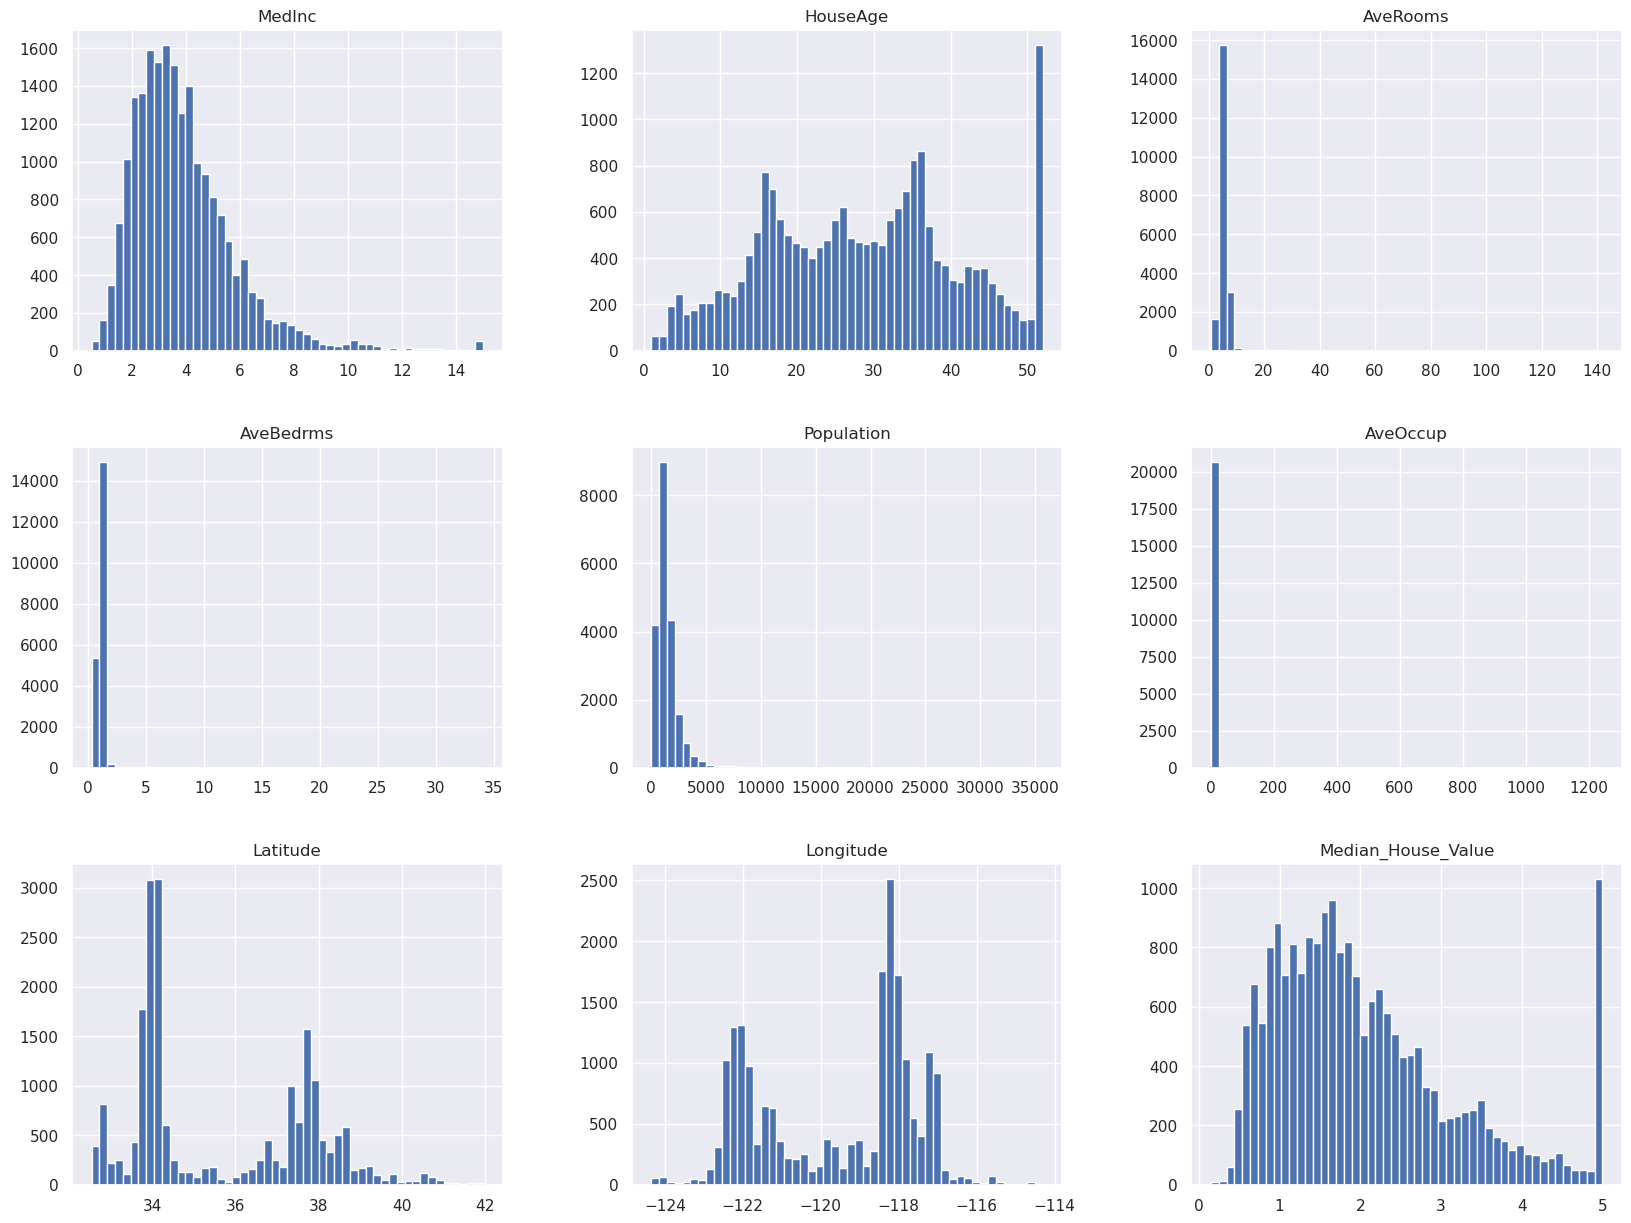

In [9]:
housing_price_dataframe.hist(bins=50, figsize=(20, 15))
plt.show()

**Ta có thể nhận thấy một vài điều từ biểu đồ này:**
- Đầu tiên, dường như thuộc tính thu nhập trung vị không được biểu diễn bằng đơn vị đô la. Trong tài liệu của scikit-learn có giải thích là đơn vị được tính theo mườn ngàn đô-la (ví dụ, 3 thực tế là 30,000 đô-la). Tương tự thì giá nhà trung vị cũng không biểu diễn bằng đô-la mà được tính theo trăm ngàn đô-la (tức 5 sẽ là 500,000 đô-la). Dữ liệu được co giãn xuống mức trần tại 15 (chính xác là 15.0001) đối với các thu nhập trung vị cao hơn, và mức sàn tại 0.5 (chính xác là 0.4999) đối với các thu nhập trung vị thấp hơn.
- Tuổi đời trung vị và giá nhà trung vị cũng được giới hạn. Việc giới hạn giá trị trung vị của ngôi nhà có thể là vấn đề nghiêm trọng vì đây là thuộc tính mục tiêu (nhãn muốn dự đoán).
- Các thuộc tính này có các khoảng giá trị rất khác nhau. Ta sẽ cần co giãn chúng về các khoảng giá trị giống nhau để các thuộc tính Học Máy có thể hoạt động hiệu quả.
- Cuối cùng nhiều biểu đồ tần suất *nặng đuôi* (*tail-heavy*): biểu đồ trải dài về bên phải trung vị hơn bên trái. Điều này sẽ khiến việc phát hiện các khuôn mẫu trong một số thuật toán Học Máy gặp đôi chút khó khăn.

## Tạo tập kiểm tra
Bây giờ, chúng ta sẽ tạm thời để một phần dữ liệu sang một bên. Cho tới hiện nay ta mới chỉ nhìn qua, và chắc rằng ta cần tìm hiểu thêm về dữ liệu trước khi quyết định sẽ sử dụng thuật toán nào. Nếu quan sát tập kiểm tra, mô hình của chúng ta rất dễ quá khớp. Ta có thể gặp một vài khuôn mẫu thú vị trong tập kiểm tra, điều này có thể khiến ta thiên kiến  lựa chọn một dạng mô hình Học Máy cụ thể. Khi đánh giá sai số khái quát trên tập kiểm tra, kết quả sẽ quá tốt. Do đó, ta sẽ đưa vào triển khai một hệ thống hoạt động tệ hơn mong đợi. Đây được gọi là thiên kiến *dòm ngó dữ liệu* (*data-snooping*). 

Scikit-learn cung cấp một vài hàm để chia một tập dữ liệu thành các tập dữ liệu con theo nhiều cách. Hàm đơn giản nhất là **train_test_split()**

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_price_dataframe, test_size=0.2, random_state=42)

In [11]:
test_set.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Median_House_Value
20046,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01,0.47700
3024,2.5313,30.0,5.039384,1.193493,1565.0,2.679795,35.14,-119.46,0.45800
15663,3.4801,52.0,3.977155,1.185877,1310.0,1.360332,37.80,-122.44,5.00001
20484,5.7376,17.0,6.163636,1.020202,1705.0,3.444444,34.28,-118.72,2.18600
9814,3.7250,34.0,5.492991,1.028037,1063.0,2.483645,36.62,-121.93,2.78000


Phương pháp lấy mẫu ngẫu nhiên như trên sẽ hoạt động ổn trên tập dữ liệu đủ lớn (đặc biệt là so với số lượng thuộc tính), nhưng nếu không, ta sẽ đối mặt với rủi ro đáng kể về thiên kiến lấy mẫu. Khi một công ty làm khảo sát trên 1,000 người, họ không chỉ lấy ngẫu nhiên 1,000 người trong danh bạ. Họ cố gắng đảm bảo 1,000 người này đại diện cho toàn bộ dân số. Ví dụ, dân số nước Mỹ có 51.3% nữ và 48.7% nam, nên một cuộc khảo sát tốt ở Mỹ sẽ cố gắng duy trì tỷ lệ này khi lấy mẫu: 513 nữ và 487 nam. Cách lấy mẫu này được gọi là *lấy mẫu stratified* (*stratified sampling*): toàn bộ tổng thể được chia thành các nhóm con đồng nhất gọi là stratum, và một số lượng mẫu xác định được lấy từ mỗi *stratum* để đảm bảo tập dữ liệu kiểm tra có tính đại diện cho toàn bộ tổng thể. Nếu người làm khảo sát chỉ đơn thuần lấy mẫu ngẫu nhiên, sẽ có khả năng phân phối của tập dữ liệu kiểm tra bị lệch, kết quả khảo sát sẽ bị thiên kiến đáng kể.

Trong tất cả các thuộc tính thì thuộc tính quan trọng để dự đoán giá nhà trung vị là thu nhập trung vị (điều này có thể dễ dàng hiểu được dựa trên thực tế). Ta cần đảm bảo rằng tập kiểm tra mang tính đại diện cho tất cả các mức thu nhập trong toàn bộ tập dữ liệu. Vì thu nhập trung vị là một thuộc tính liên tục, đầu tiên ta cần tạo thuộc tính hạng mục để biểu diễn các mức thu nhập khác nhau. Hãy quan sát biểu đồ tần suất của thu nhập trung vị kỹ hơn.

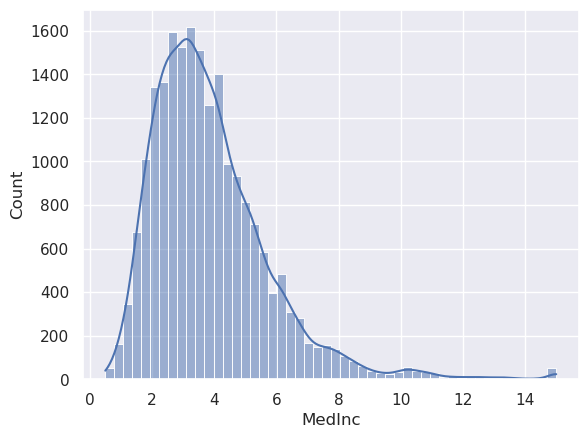

In [12]:
sns.histplot(data=housing_price_dataframe, x='MedInc', bins=50, kde=True);

Phần lớn các giá trị thu nhập trung vị được phân bố trong khoảng từ 1.5 đến 6 (tức $15,000-$60,000), nhưng có vài giá trị vượt quá 6. Việc có đủ mẫu trong tập dữ liệu cho mỗi stratum là rất quan trọng. Nếu không, việc ước lượng độ quan trọng của một stratum sẽ bị thiên kiến. Nghĩa là, không nên có quá nhiều stratum, và mỗi stratum nên đủ lớn. Chúng ta sẽ sử dụng hàm **pd.cut()** để tạo thuộc tính mức thu nhập theo năm mức (gán nhãn từ 1 đến 5): mức 1 từ 0 đến 1.5 (tức dưới $15,000), mức 2 từ 1.5 đến 3, v.v.

In [13]:
housing_price_dataframe['income_cat'] = pd.cut(housing_price_dataframe['MedInc'], bins=[0., 1.5, 3., 4.5, 6., np.inf],
                                               labels=[1, 2, 3, 4, 5])

Ta có thể biết tất cả hạng mục cũng như số quận thuộc mỗi hạng mục bằng cách sử dụng phương thức **value_counts()**

In [14]:
housing_price_dataframe['income_cat'].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

Các mức thu nhập được biểu diễn như hình dưới

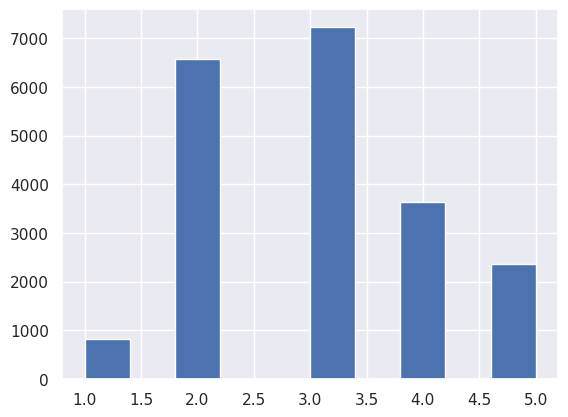

In [15]:
housing_price_dataframe['income_cat'].hist();

Bây giờ ta đã sẵn sàng lấy mẫu stratified dựa trên các mức thu nhập. Để thực hiện việc này, ta có thể sử dụng lớp **StratifiedShuffleSplit** của Scikit-learn.

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_price_dataframe, housing_price_dataframe['income_cat']):
    strat_train_set = housing_price_dataframe.loc[train_index]
    strat_test_set = housing_price_dataframe.loc[test_index]

Ta sẽ kiểm tra xem việc chia dữ liệu trên hoạt động đúng không, bắt đầu bằng việc quan sát tỷ lệ phần trăm các mức thu nhập trong tập kiểm tra.

In [17]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [18]:
housing_price_dataframe['income_cat'].value_counts() / len(housing_price_dataframe)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

Tương tự ta có thể đo lường tỷ lệ phần trăm của các mức thu nhập trong toàn bộ tập dữ liệu

In [19]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


train_set, test_set = train_test_split(housing_price_dataframe, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing_price_dataframe),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [20]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
income_cat,,,,,
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


Qua bảng so sánh trên ta có thể thấy, lấy mẫu stratified tạo ra tập dữ liệu kiểm tra có tỷ lệ các mức thu nhập khá giống với tỷ lệ trong tập dữ liệu gốc, trong khi phân phối của tập dữ liệu lấy mẫu ngẫu nhiên bị lệch.

Giờ ta có thể loại bỏ thuộc tính **income_cat** để dữ liệu trở về trạng thái ban đầu.

In [21]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 3. Khám phá và Trực quan hóa Dữ liệu để có được Thông tin Chi tiết
* Cho tới nay ta mới chỉ nhìn lướt qua dữ liệu để nắm được các đặc điểm chung của chúng. Bây giờ mục tiêu của ta là đi sâu hơn một chút.
* Đầu tiên, hãy đảm bảo rằng ta không động vào tập kiểm tra và chỉ sử dụng tập huấn luyện. Ngoài ra, nếu tập huấn luyện rất lớn, ta có thể chỉ lấy ra một tập nhỏ để việc thao tác dễ và nhanh hơn. Trong trường hợp này, tập huấn luyện tương đối nhỏ, nên ta có thể làm việc trực tiếp trên toàn bộ tập. Hãy tạo một bản sao để yên tâm rằng ta không làm ảnh hưởng đến tập huấn luyện gốc.

In [22]:
housing_price_dataframe = strat_train_set.copy()

## Trực quan hóa Dữ liệu Địa lý
Vì dữ liệu có các thông tin về địa lý (kinh độ và vĩ độ), ta nên tạo một biểu đồ phân tán (*scatterplot*) của tất cả các quận để trực quan hóa dữ liệu.

<Axes: xlabel='Longitude', ylabel='Latitude'>

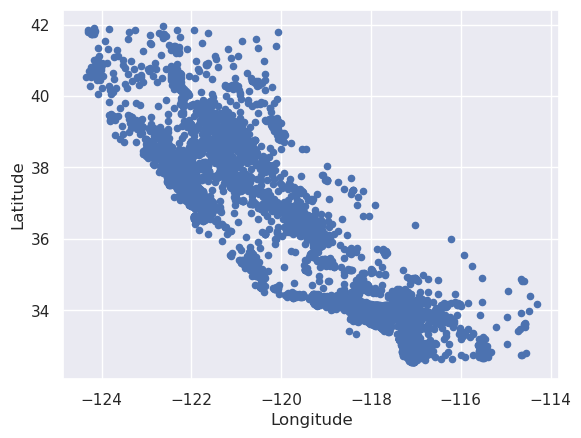

In [23]:
housing_price_dataframe.plot(kind="scatter", x="Longitude", y="Latitude")

Biểu đồ này nhìn khá giống hình dáng bang California, nhưng ngoài điều đó ra thì rất khó để thấy được khuôn mẫu cụ thể nào.
Ta sẽ vẽ biểu đồ với nhiều thông tin hơn: bán kính mỗi vòng tròn đại diện cho dân số của quận, màu sắc đại diện cho mức giá. Ta sẽ sử dụng một bảng màu định nghĩa sẵn (đối số **cmap**) có tên là **jet**, có dải màu từ xanh (giá thấp) đến đỏ (giá cao).

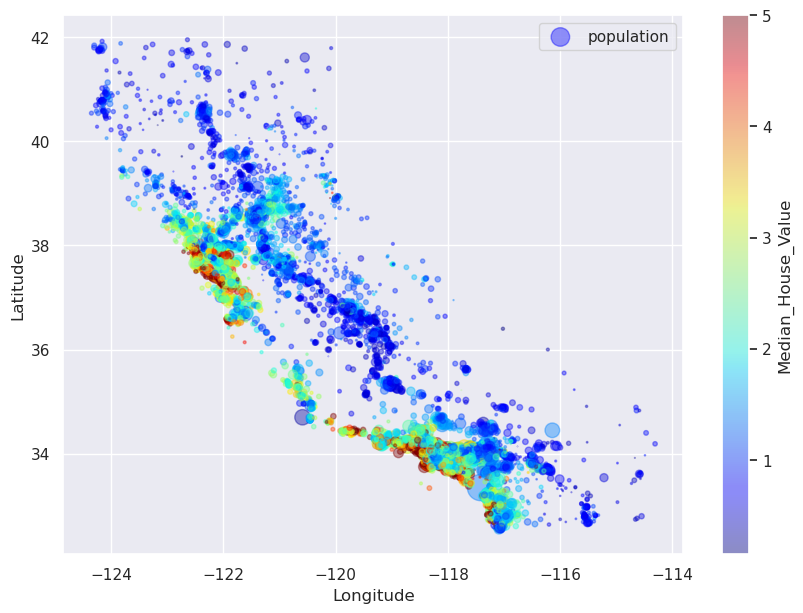

In [24]:
housing_price_dataframe.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
                             s=housing_price_dataframe["Population"] / 100, label="population", figsize=(10, 7),
                             c="Median_House_Value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend();

Hình ảnh này cho thấy giá nhà liên quan mật thiết đến vị trí (như gần biển) và mật độ dân số, như ta có thể đã biết. Khoảng cách đến biển cũng có thể là một thuộc tính hữu ích, tuy vậy ở Bắc California giá nhà ở các quận vùng vịnh lại không quá cao, vì thế đây không phải là một quy tắc đơn giản.

## Tìm sự Tương quan
Vì tập dữ liệu không quá lớn, ta có thể dễ dàng tính được *hệ số tương quan chuẩn* (*standard correlation coefficient*, còn được gọi là *hệ số tương quan Pearson r*) giữa các cặp thuộc tính bằng phương thức phương thức **corr()**.

In [25]:
corr_matrix = housing_price_dataframe.corr()

Chúng ta sẽ sử dụng tạo một heatmap để nhìn rõ được sự tương quan giữa các thuộc tính.

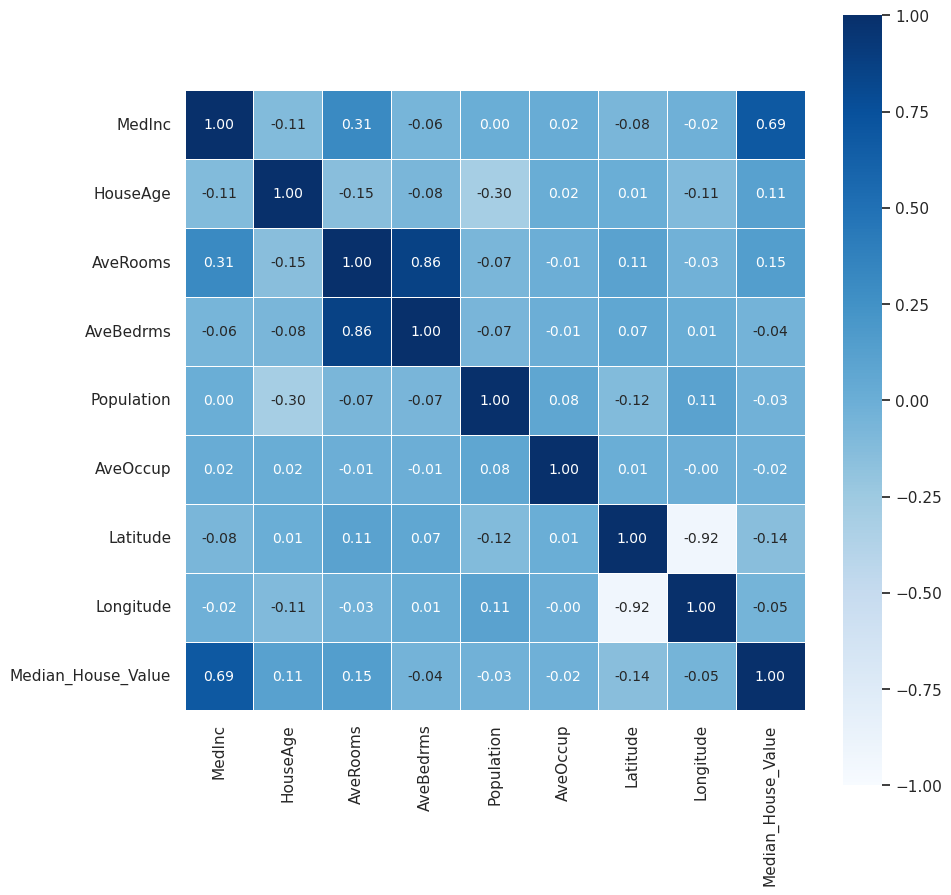

In [26]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, cbar=True, square=True, fmt='.2f', annot=True, annot_kws={'size': 10}, cmap='Blues', vmin=-1,
            vmax=1, linecolor='white', linewidths=0.5);

Một cách khác để kiểm tra mối quan hệ tương quan giữa các thuộc tính là sử dụng hàm **scatter_matrix()** của pandas để vẽ đồ thị biểu diễn mối quan hệ giữa các thuộc tính số với nhau. Vì giờ có 9 thuộc tính số, nên ta sẽ có 8*8 = 64 đồ thị. Do chúng không nằm vừa trong một trang giấy nên hãy tập trung vào một vài thuộc tính hứa hẹn sẽ có tương quan cao hơn với giá nhà trung vị.

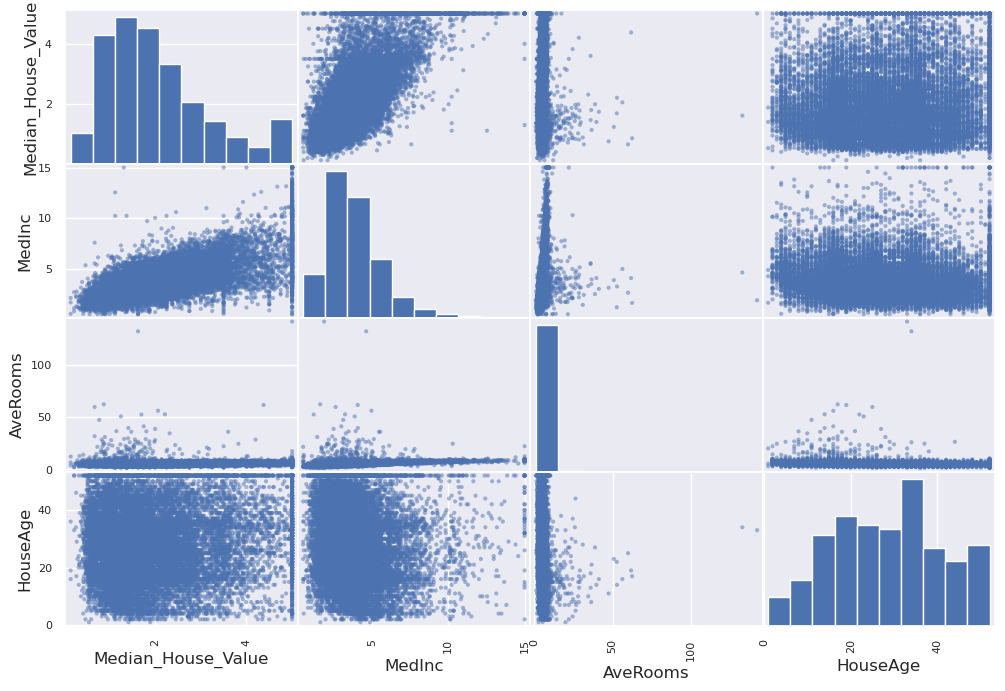

In [27]:
from pandas.plotting import scatter_matrix

attributes = ["Median_House_Value", "MedInc", "AveRooms",
              "HouseAge"]
scatter_matrix(housing_price_dataframe[attributes], figsize=(12, 8));

## Tìm kiếm Mối tương quan
Qua 2 đồ thị trên, ta có thể thấy thuộc tính hứa hẹn nhất để dự đoán giá trị nhà trung vị là thu nhập trung vị (đúng như ta dự đoán ở trên khi tạo tập kiểm tra), nên hãy phóng to đồ thị phân tán tương quan của chúng.

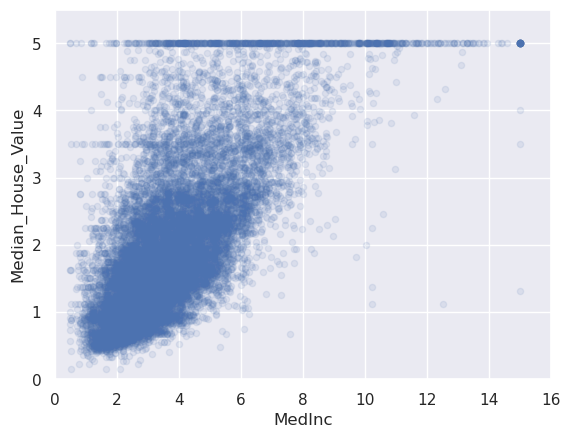

In [28]:
housing_price_dataframe.plot(kind="scatter", x="MedInc", y="Median_House_Value", alpha=0.1)
plt.axis((0, 16, 0, 5.5));

**Biểu đồ này nói lên vài điều**:
- Đầu tiên, sự tương quan thật sự rất mạnh. Bạn có thể thấy rõ xu hướng đi lên trong khi các điểm dữ liệu thì không quá phân tán.
- Thứ hai, mức giá trần chúng ta thấy trước đó đã được hiển thị rõ ràng bằng một đường ngang tại 500,000 đô.
- Tuy nhiên, biểu đồ này cũng tiết lộ một vài đường ngang khó nhận thấy ngay: một đường quanh 450,000 đô, một đường khác ở khoảng 350,000 đô, một đường khác ở khoảng 280,000 đô, và một vài đường phía dưới nữa.

# 4. Chuẩn bị dữ liệu cho các thuật toán Học Máy
Giờ là lúc chuẩn bị dữ liệu cho các thuật toán Học Máy. Nhưng trước hết, ta sẽ quay lại tập huấn luyện ban đầu (bằng cách sao chép **strat_train_set**) một lần nữa. Cùng với đó, ta sẽ tách các thuộc tính và nhãn, vì ta không nhất thiết muốn áp dụng các phép biến đổi lên cả hai. 

In [29]:
housing = strat_train_set.drop('Median_House_Value', axis=1)
housing_labels = strat_train_set['Median_House_Value'].copy()

## Co giãn Đặc trưng
Một trong số những phép biến đổi quan trọng nhất mà ta cần thực hiện trên dữ liệu đó là *co giãn đặc trưng* (*feature scaling*). Ngoài một số ít trường hợp ngoại lệ, các thuật toán Học Máy không hoạt động tốt khi các đặc trưng đầu vào có khoảng giá trị khác nhau. Vấn đề này xảy ra trong dữ liệu nhà ở: tổng số phòng nằm trong khoảng từ 6 tới 39,320, trong khi thu nhập trung vị chỉ dao động từ 0 tới 15. Lưu ý rằng việc co giãn các giá trị mục tiêu (nhãn) thường không cần thiết.
Hai cách phổ biến nhất để đưa các thuộc tính về cùng một khoảng giá trị là: *co giãn min-max* (*min-max scaling*) và *chuẩn tắc hóa* (*standardization*).
* Co giãn min-max là phương pháp đơn giản nhất: các giá trị được dịch chuyển và co giãn sao cho chúng nằm trong khoảng từ 0 tới 1. Chúng ta thực hiện điều này bằng cách trừ đi giá trị nhỏ nhất và chia cho hiệu của giá trị lớn nhất và nhỏ nhất. Scikit-Learn cung cấp một bộ biến đổi có tên là **MinMaxScaler** để thực hiện phép biến đổi này. Bộ biến đổi này chứa siêu tham số **feature_range** cho phép thay đổi khoảng giới hạn trong trường hợp ta không muốn sử dụng khoảng [0, 1].
* Chuẩn tắc hóa thì khác: đầu tiên ta trừ đi giá trị trung bình (vì vậy các giá trị chuẩn tắc luôn có giá trị trung bình bằng 0), sau đó chia cho độ lệch chuẩn để phân phối thu được có phương sai đơn vị. Không giống như min-max scaling, chuẩn tắc hóa không ràng buộc các giá trị phải nằm trong một khoảng cụ thể. Điều này có thể trở thành vấn đề đối với một số thuật toán (ví dụ như mạng nơ-ron thường yêu cầu đầu vào nằm trong khoảng từ 0 tới 1). Tuy nhiên, chuẩn tắc hóa lại ít bị ảnh hưởng bởi các điểm ngoại lai. Ví dụ, giả sử một quận có thu nhập trung bình bằng 100 (do nhầm lẫn). Khi đó min-max scaling sẽ co tất cả các giá trị khác từ [0, 15] xuống [0, 0.15], còn chuẩn tắc hóa sẽ không bị ảnh hưởng đáng kể. Scikit-Learn cung cấp một bộ biến đổi gọi là **StandardScaler** cho việc chuẩn tắc hóa.

In [30]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_prepared = std_scaler.fit_transform(housing)

In [31]:
housing_prepared

array([[-0.8936472 ,  0.02756357,  0.01739526, ...,  0.00622264,
         1.34743822, -0.94135046],
       [ 1.292168  , -1.72201763,  0.56925554, ..., -0.04081077,
        -1.19243966,  1.17178212],
       [-0.52543365,  1.22045984, -0.01802432, ..., -0.07537122,
        -0.1259716 ,  0.26758118],
       ...,
       [-0.36547546,  1.53856552, -0.5092404 , ..., -0.03743619,
         1.31001828, -1.5707942 ],
       [ 0.16826095, -1.1653327 ,  0.32814891, ..., -0.05915604,
         1.2492109 , -1.56080303],
       [-0.390569  , -0.13148926,  0.01407228, ...,  0.00657083,
         2.02567448, -1.28105026]])

In [32]:
housing_prepared.shape

(16512, 8)

# 5. Chọn và Huấn luyện một mô hình
Ta đã định nghĩa xong bài toán, thu thập và khám phá dữ liệu, lấy mẫu tập huấn luyện và tập kiểm tra, rồi co giãn đặc trưng để chuẩn bị dữ liệu cho các thuật toán Học Máy

## Huấn luyện và đánh giá trên tập huấn luyện
Nhờ có những bước trên, mọi thứ đã trở nên đơn giản hơn nhiều.
Đầu tiên, ta sẽ huấn luyện một mô hình Hồi quy Tuyến tính (Linear Regression).

In [65]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

Ta sẽ đo RMSE của mô hình này trên toàn bộ tập huấn luyện trực tiếp bằng hàm **mean_squared_error()** có sẵn trong Scikit-learn với đố số **squared=False**.

In [66]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse

0.7271433201356049

Ta cũng sẽ đo MAE của mô hình trên toàn bộ tập huấn luyện

In [67]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

0.5330319478243066

Rõ ràng kết quả này không tốt: giá trị Median_House_Value ở hầu hết các quận nằm trong khoảng 100,000 đô và 300,000 đô, nên sai lệch khoảng 72,727 đô (ta phải nhân kết quả trên với 100,000 vì đơn vị của giá nhà trung vị là 100,000) chưa thể làm ta hài lòng. Đây là một ví dụ cho việc mô hình dưới khớp dữ liệu huấn luyện. Khi điều này xảy ra, có thể các đặc trưng không cung cấp đủ thông tin để đưa ra dự đoán tốt, hoặc cũng có thể mô hình vẫn chưa đủ mạnh. Những phương pháp chính để giải quyết vấn đề dưới khớp là chọn một mô hình mạnh hơn, cung cấp đặc trưng tốt hơn cho thuật toán hoặc giảm các điều kiện ràng buộc lên mô hình. Mô hình này chưa được điều chuẩn nên ta có thể loại trừ phương án cuối cùng. Ta có thể thử thêm các đặc trưng khác (ví dụ như log của dân số), nhưng trước tiên hãy thử sử dụng một mô hình phức tạp hơn để xem kết quả ra sao.

Ta sẽ huấn luyện một **DecisionTreeRegressor**. Đây là một mô hình mạnh mẽ và có khả năng tìm ra các quan hệ phi tuyến trong dữ liệu.

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [36]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse

2.7802870411261065e-16

Chúng ta nhận thấy một điều đặc biệt là sai số quá thấp, đến mức dường như không có sai lệch. Liệu mô hình này hoàn hảo tuyệt đối không?
Tất nhiên khả năng cao là mô hình đã quá khớp dữ liệu huấn luyện một cách nặng nề. Làm thế nào để xác định điều này? Như đề cập ở trên, ta không muốn động vào tập kiểm tra cho đến khi sẵn sàng triển khai mô hình đáng tin cậy. Vì vậy, ta cần phải dành riêng một phần của tập huấn luyện cho việc kiểm định mô hình và phần còn lại cho việc huấn luyện.

## Kiểm định Chéo: Phương pháp Đánh giá tốt hơn
Chúng ta sẽ sử dụng tính năng *kiểm định chéo K-fold* (*K-fold cross-validation*) của Scikit-Learn. Đoạn mã dưới đây chia ngẫu nhiên tập huấn luyện thành 10 tập con riêng biệt gọi là *fold*, rồi huấn luyện và đánh giá mô hình Cây Quyết định 10 lần, mỗi lần chọn một fold khác nhau để đánh giá và huấn luyện trên 9 fold còn lại. Kết quả là một mảng chứa 10 điểm số đánh giá.

In [37]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [38]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [39]:
display_scores(tree_rmse_scores)

Scores: [0.78803277 0.71720516 0.69716242 0.73328362 0.71601481 0.75473669
 0.74402568 0.73505469 0.67654774 0.72810837]
Mean: 0.7290171954485472
Standard deviation: 0.029157198696304565


Chúng ta sẽ tính điểm số tương tụ như trên cho mô hình Hồi quy Tuyến tính để có sự so sánh chắc chắn.

In [40]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [0.74571946 0.69960318 0.7186325  0.74445404 0.70953926 0.76172221
 0.74576182 0.72513212 0.70844341 0.74241372]
Mean: 0.7301421715595152
Standard deviation: 0.019557260437567264


So sánh 2 kết quả, chúng ta có thể thấy mô hình Cây Quyết định không tốt hơn mô hình Hồi quy Tuyến tính quá nhiều như khi không dùng kiểm định chéo.

Giờ chúng ta sẽ thử mô hình **RandomForestRegressor**. Rừng Ngẫu nhiên hoạt động bằng cách huấn luyện nhiều Cây Quyết định với các tập con đặc trưng ngẫu nhiên, rồi lấy trung bình dự đoán của chúng. Xây dựng mô hình dựa trên nhiều mô hình khác được gọi là *Học Emsemble*, và đây thường là cách tốt để cải thiện hơn nữa các thuật toán Học Máy.

In [41]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [42]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
forest_rmse

0.18988442884137502

In [43]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.54108026 0.49827496 0.46700769 0.52149227 0.47753405 0.51925719
 0.54140228 0.50211363 0.48522757 0.53970279]
Mean: 0.5093092688616518
Standard deviation: 0.026005881329534148


Kết quả này tốt hơn nhiều so với 2 kết quả ở trên. Ta có thể thấy Rừng ngẫu nhiên có vẻ rất hứa hẹn. Tuy nhiên, lưu ý rằng điểm số trên tập huấn luyện vẫn thấp hơn nhiều so với trên tập kiểm định, có nghĩa rằng là mô hình vẫn quá khớp trên tập huấn luyện.
Các giải pháp khả thi cho hiện tượng quá khớp là đơn giản hóa mô hình, ràng buộc mô hình (tức điều chuẩn), hoặc thu thập nhiều dữ liệu huấn luyện hơn nữa.

Bây giờ, ta sẽ thử một mô hình Học Máy khác là Máy Vector Hỗ trợ (Support Vector Machine).

In [44]:
from sklearn.svm import SVR

svm_reg = SVR(kernel='linear')
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
svm_rmse

0.9741682923756361

In [45]:
svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
svm_rmse_sccores = np.sqrt(-svm_scores)
display_scores(svm_rmse_sccores)

Scores: [0.74860002 0.70221162 0.73795413 1.31349494 3.87787174 0.77928454
 0.80992095 1.22194279 0.71172396 0.74490907]
Mean: 1.1647913763669384
Standard deviation: 0.9279918741667003


Có vẻ như mô hình SVM không phù hợp trong bài toán này nên nó cho ra kết quả tệ nhất từ nãy đến giờ, tệ hơn cả một mô hình đơn giản là Hồi quy Tuyến tính.

Những gì chúng ta làm đến giờ là để chọn ra một vài mô hình triển vọng (từ hai đến năm mô hình) rồi sau đó chúng ta mới dành thời gian để tinh chỉnh các siêu tham số.

# 6. Tinh chỉnh Mô hình
Bây giờ, ta đã có một danh sách những mô hình triển vọng và cần được tinh chỉnh. Ta sẽ thử qua vài cách để thực hiện việc này.

## Tìm kiếm dạng Lưới
Ta sẽ sử dụng **GridSearchCV** trong Scikit-Learn để tìm kiếm một bộ siêu tham số phù hợp. Ta chỉ cần chỉ rõ những siêu tham số muốn tinh chỉnh và các giá trị nào cần thử, rồi **GridSearchCV** sẽ sử dụng phương pháp kiểm định chéo để đánh giá tất cả các cách kết hợp khả thi của các giá trị siêu tham số. Đoạn mã dưới đây sẽ tìm kiếm bộ giá trị tốt nhất cho các siêu tham số của **Random ForestRegressor**.

In [46]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # thử 3x4=12 cách kết hợp siêu tham số
    {'n_estimators': [10, 20, 50], 'max_features': [2, 4, 6, 8]},
    # sau đó thử 2x3=6 các kết hợp với "bootstrap" được đặt là False
    {'bootstrap': [False], 'n_estimators': [10, 20], 'max_features': [2, 3, 4]}
]

In [47]:
forest_reg = RandomForestRegressor(random_state=42)
# nó sẽ huấn luyện qua 5 fold, vậy tổng cộng nó sẽ có (12+6)*5=90 lần huấn luyện
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [10, 20, 50]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [10, 20]}],
             return_train_score=True, scoring='neg_mean_squared_error')

Việc này sẽ tốn khá nhiều thời gian, nhưng khi hoàn thành, ta có thể tìm được một bộ giá trị tốt nhất cho các siêu tham số.

In [48]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 3, 'n_estimators': 20}

Ta cũng sẽ thu được bộ ước lượng một cách trực tiếp

In [49]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=3, n_estimators=20,
                      random_state=42)

Ta cũng có được điểm số đánh giá

In [50]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.5418447550624238 {'max_features': 2, 'n_estimators': 10}
0.5225587795712359 {'max_features': 2, 'n_estimators': 20}
0.5086578652501371 {'max_features': 2, 'n_estimators': 50}
0.5405493738942803 {'max_features': 4, 'n_estimators': 10}
0.5200500466566027 {'max_features': 4, 'n_estimators': 20}
0.5062181495346713 {'max_features': 4, 'n_estimators': 50}
0.5372842958800104 {'max_features': 6, 'n_estimators': 10}
0.5211771726226055 {'max_features': 6, 'n_estimators': 20}
0.5115459817486925 {'max_features': 6, 'n_estimators': 50}
0.5422395363409677 {'max_features': 8, 'n_estimators': 10}
0.5258568205438104 {'max_features': 8, 'n_estimators': 20}
0.5173620004551535 {'max_features': 8, 'n_estimators': 50}
0.5238925001769789 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.5037917665444529 {'bootstrap': False, 'max_features': 2, 'n_estimators': 20}
0.5206566358077966 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
0.49915937566302016 {'bootstrap': False, 'max_features'

Thông qua cách làm này, chúng ta đã tìm được mô hình tốt nhất bằng cách đặt giá trị các siêu tham số **bootstrap** là False, **max_features** là 3 và **n_estimators** là 20.
Điểm RMSE cho cách kết hợp này là 0,499159, tốt hơn một chút so với các giá trị mặc định của siêu tham số trước đó (là 0.509309).
Chúng ta đã thành công tinh chỉnh mô hình tốt nhất của mình.

## Tìm kiếm Ngẫu nhiên
Tìm kiếm dạng lưới có thể được dùng để khám phá tương đối ít các cách kết hợp như cách trên, nhưng khi không gian tìm kiếm siêu tham số lớn hơn thì ta nên ưu tiên dùng **Randomized SearchCV**. Lớp này có thể được sử dụng tương tự như lớp **GridSearchCV**, nhưng thay vì thử tất cả các cách kết hợp khả thi, nó sẽ đánh giá một số cách kết hợp ngẫu nhiên nhất định bằng cách chọn một giá trị ngẫu nhiên cho mỗi siêu tham số tại mỗi lần lặp. Phương pháp này có hai lợi ích chính sau đây:
- Nếu ta để thuật toán tìm kiếm ngẫu nhiên chạy 1,000 lần lặp, nó sẽ khám phá 1,000 giá trị khác nhau cho mỗi siêu tham số (thay vì chỉ một vài giá trị trên mỗi siêu tham số như trong tìm kiếm dạng lưới).
- Chỉ cần nhập số lần lặp, ta sẽ kiểm soát tốt hơn tài nguyên tính toán được phân bổ cho việc tìm kiếm siêu tham số.

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8)
}

In [52]:
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=5,
                                scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa287a3a8d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa287a3b150>},
                   random_state=42, scoring='neg_mean_squared_error')

In [53]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.5097436189313215 {'max_features': 7, 'n_estimators': 180}
0.524425591565228 {'max_features': 5, 'n_estimators': 15}
0.49899961664697473 {'max_features': 3, 'n_estimators': 72}
0.5179569223148902 {'max_features': 5, 'n_estimators': 21}
0.5114073870167402 {'max_features': 7, 'n_estimators': 122}
0.49812604287124973 {'max_features': 3, 'n_estimators': 75}
0.49879977066161024 {'max_features': 3, 'n_estimators': 88}
0.5049001682804082 {'max_features': 5, 'n_estimators': 100}
0.4983909928408596 {'max_features': 3, 'n_estimators': 150}
0.6504488908013953 {'max_features': 5, 'n_estimators': 2}


In [54]:
rnd_search.best_params_

{'max_features': 3, 'n_estimators': 75}

## Phân tích các Mô hình Tốt nhất và Lỗi của Chúng
Ta thường có thêm những hiểu biết sâu hơn về bài toán bằng cách kiểm tra các mô hình tốt nhất. Ví dụ: **RandomForestRegressor** có thể tính được độ quan trọng tương đối của mỗi thuộc tính để đưa ra dự đoán chính xác.

In [55]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.38902309, 0.05309161, 0.10893341, 0.03237185, 0.03154755,
       0.12747322, 0.13431977, 0.1232395 ])

Ta sẽ in ra các điểm số thể hiện độ quan trọng cùng với tên các thuộc tính tương ứng.

In [56]:
attributes = list(housing_price_dataframe.columns)
attributes = attributes[:-1]
sorted(zip(feature_importances, attributes), reverse=True)

[(0.38902308693119003, 'MedInc'),
 (0.13431977217517424, 'Latitude'),
 (0.12747322438985728, 'AveOccup'),
 (0.12323950286656656, 'Longitude'),
 (0.10893340768135291, 'AveRooms'),
 (0.053091607234303305, 'HouseAge'),
 (0.032371851469154916, 'AveBedrms'),
 (0.03154754725240076, 'Population')]

Với thông tin này, ta có thể loại bỏ một số đặc trưng ít hữu dụng.
Ta cũng nên xem xét các lỗi cụ thể mà hệ thống mắc phải, từ đó cố gắng hiểu nguyên nhân và tìm ra cách khắc phục vấn đề (như thêm các đặc trưng bổ sung hoặc loại bỏ các đặc trưng không có giá trị, loại bỏ các mẫu ngoại lai, v.v.).

# 7. Đánh giá Hệ thống trên Tập Kiểm tra
Sau khi tinh chỉnh xong các mô hình, ta đã có một hệ thống hoạt động đủ tốt. Bây giờ là lúc để đánh giá mô hình cuối cùng trên tập dữ liệu kiểm tra. Không có gì đặc biệt về quá trình này: chỉ cần lấy các đặc trưng và nhãn từ tập kiểm tra, biến đổi dữ liệu (gọi hàm **transform()** thay vì **fit_transform()**, bởi ta không muốn khớp trên tập kiểm tra!), và đánh giá mô hình cuối cùng trên tập kiểm tra.

In [57]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('Median_House_Value', axis=1)
y_test = strat_test_set['Median_House_Value'].copy()

X_test_prepared = std_scaler.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

0.48339352102642

## Mô hình persistence sử dụng joblib

In [58]:
import joblib

joblib.dump(final_model, 'final_model.pkl')

['final_model.pkl']

## Kiểm tra mô hình đã lưu

In [59]:
my_model = joblib.load('final_model.pkl')
final_predictions = my_model.predict(X_test_prepared)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

0.48339352102642

# 8. Triển khai, Theo dõi, và Bảo trì Hệ thống
**Ở dự án này, chúng ta sẽ dừng ở việc dự đoán và đánh giá mô hình, sẽ không triển khai gì hết, nếu có sẽ ở một dự án khác.**

# 9. Bonus
## Phương pháp Emsemble
Một cách nữa để tinh chỉnh hệ thống là thử kết hợp các mô hình hoạt động tốt nhất. Nhóm (hoặc "ensemble") các mô hình riêng lẻ này thường sẽ hoạt động tốt hơn so với một mô hình riêng lẻ tốt nhất (giống như Rừng Ngẫu nhiên hoạt động tốt hơn Cây Quyết định riêng lẻ), đặc biệt nếu các mô hình riêng lẻ mắc các lỗi rất khác nhau.
*Boosting* (ban đầu được gọi là *boosting giả thuyết* - *hypothesis boosting*) là bất cứ phương pháp Ensemble nào có thể kết hợp một vài bộ học yếu thành một bộ học mạnh. Ý tưởng chung của hầu hết các phương pháp boosting là huấn luyện tuần tự các bộ dự đoán, bộ dự đoán sau cố gắng sửa lỗi cho bộ dự đoán trước. Có nhiều phương pháp boosting nhưng hiện nay phổ biến nhất là Ada Boost (viết tắt của Adaptive Boosting) và Gradient Boosting.
Bây giờ ta sẽ sử dụng một mô hình Gradient Boosting. Hiện mô hình đang có sẵn ở thư viện Python nổi tiếng XGBoost (viết tắt của Extreme Gradient Boosting). Trên thực tế, XGBoost thường là một mô hình quan trọng trong nhiều thắng lợi tại các cuộc thi Học Máy.

In [60]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor()
xgb_reg.fit(housing_prepared, housing_labels)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [61]:
housing_predictions = xgb_reg.predict(housing_prepared)
xgb_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
xgb_rmse

0.2708038003402311

In [62]:
xgb_scores = cross_val_score(xgb_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
xgb_rmse_sccores = np.sqrt(-xgb_scores)
display_scores(xgb_rmse_sccores)

Scores: [0.50073449 0.46285005 0.4352951  0.48803517 0.46188253 0.48394241
 0.49288826 0.46759605 0.46540443 0.51152139]
Mean: 0.4770149893366077
Standard deviation: 0.021373835794219778


In [63]:
final_predictions = xgb_reg.predict(X_test_prepared)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

0.45953378979359505

In [64]:
best_model = xgb_reg
joblib.dump(best_model, 'best_model.pkl')
best_model = joblib.load('best_model.pkl')
final_predictions = xgb_reg.predict(X_test_prepared)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

0.45953378979359505

# 10. Tổng kết
**Qua dự án này, chúng ta đã biết được và thực hành các bước để thực hiện một dự án Học Máy từ đầu đến cuối nói chung và giải quyết bài toán hồi quy (cụ thể là dự đoán giá nhà) nói riêng**.
**Mình hi vọng dự án này giúp ích được nhiều cho mọi người trong việc theo đuổi con đường Học Máy!!!**